# Site

The `Site` object provides the free wind conditions at the site including mean wind, shear, turbulence etc.

Current implementations are:
- TurbulenceFieldSite

## TurbulenceFieldSite

In [1]:
# imports and default values
import numpy as np
import matplotlib.pyplot as plt
from py_wake.utils.plotting import setup_plot
from dynamiks.sites import TurbulenceFieldSite
from dynamiks.sites.turbulence_fields import MannTurbulenceField, RandomTurbulence
from dynamiks.sites.mean_wind import ConstantWindSpeed
from dynamiks.views import ZView, XYView
from dynamiks.utils.test_utils import DefaultDWMFlowSimulation

ws = 10
ti = 0.1
no_turb_field = RandomTurbulence(ti=0, ws=ws) # turbulence field without turbulence

The `TurbulenceFieldSite` implements a site defined by a wind speed (object) and a turbulence field

In [2]:
help(TurbulenceFieldSite.__init__)

Help on function __init__ in module dynamiks.sites._site:

__init__(self, ws, turbulenceField, turbulence_offset=[0, 0, 0], turbulence_transport_speed=None)
    Site with mean wind and turbulence field
    
    Parameters
    ----------
    ws : int, float or MeanWind-object
        mean wind speed or MeanWind-object, e.g. ConstantWindSpeed
    turbulenceField : TurbulenceField
        E.g. MannTurbulenceField
    turbulence_offset : tuple(x,y,z), optional
        turbulence (x,y,z)-offset. Default is no offset
    turbulence_transport_speed : int, float or None, optional
        Turbulence field advection speed.
        If None (default), the speed is obtained from the mean wind speed



### Mean wind

The mean wind argument can be either a constant uniform mean wind speed value 

In [3]:
site = TurbulenceFieldSite(ws, no_turb_field)

or a ConstantWindSpeed object

In [4]:
const_ws = ConstantWindSpeed(ws=10)
site = TurbulenceFieldSite(const_ws, no_turb_field)

#### Shear
The latter `ConstantWindSpeed` option allows specification of vertical shear in terms of a PyWake shear object, e.g. `PowerShear` or `LogShear`


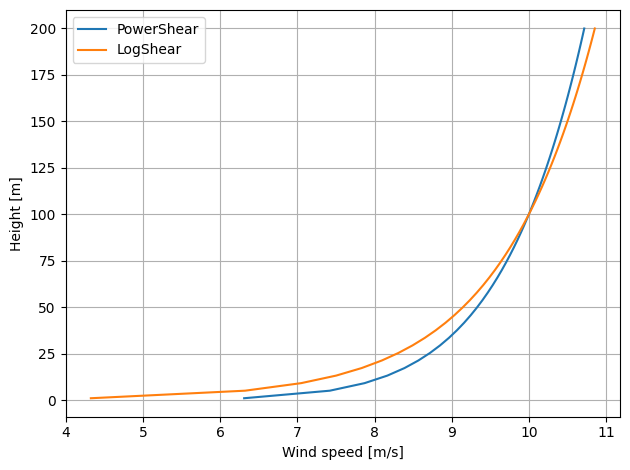

In [5]:
import numpy as np
from py_wake.site.shear import PowerShear, LogShear


# PyWake shears
power_shear = PowerShear(h_ref=100, # reference height 
                   alpha=0.1) # power shear exponent

log_shear = LogShear(h_ref=100, # reference height
                 z0=0.03)   # roughness length

view = ZView(x=0,y=0, z=np.linspace(1,200))

for shear in [power_shear, log_shear]:
    const_ws = ConstantWindSpeed(ws=10, shear=shear)
    site = TurbulenceFieldSite(const_ws, no_turb_field)
    u,v,w = site.get_windspeed(view)
    plt.plot(u, view.z, label=shear.__class__.__name__)
setup_plot(xlabel='Wind speed [m/s]', ylabel='Height [m]')

## TurbulenceField

Current implementations
- RandomTurbulence
- MannTurbulenceField

### RandomTurbulence

The `RandomTurbulence` produces random turbulence. It is very fast but mainly usable for tests

In [6]:
from dynamiks.sites.turbulence_fields import RandomTurbulence
site = TurbulenceFieldSite(10, RandomTurbulence(ti=ti, ws=ws))

In [7]:
uvw = site.get_windspeed(view)
for ws, n in zip(uvw, 'uvw'):
    plt.plot(ws, view.z, label=n)
setup_plot(xlabel='Wind speed [m/s]', ylabel='Height [m]')

### MannTurbulenceField

The `MannTurbulenceField` extends the `hipersim.MannTurbulenceField` from (see https://hipersim.pages.windenergy.dtu.dk/hipersim/MannTurbulenceField.html).

The turbulence can be generated via [Hipersim](https://hipersim.pages.windenergy.dtu.dk/hipersim/) and/or read from a netcdf or the tree-file binary Mann turbulence format.

The **turbulence field size** should cover the whole wind farm in all dimensions and time:
- Lx = Nx*dx: Farm length in direction of wind + Simulation time * turbulence transport speed.
- Ly = Ny*dy: Farm width (perpendicular to the wind)
- Lz = Nz*dz: from ground to blade tip height

The needed **grid resolution** depends on the wind turbine model. For HAWC2 (actuator line), Liew (2022) recommends a resolution of D/50.

In a study of the Lillgrund wind farm (Liew 2023), a turbulence field with 38880x1792x64 grid points is used. The size of this field is 50Gb (3 uvw components and 32bit floats). Note, that such big files usually requires a HPC system, as personal computers have far less memory.

Reference:
- Jaime Liew and Gunner Chr. Larsen 2022 J. Phys.: Conf. Ser. 2265 032049, https://doi.org/10.1088/1742-6596/2265/3/032049)
- Jaime Liew et al 2023 J. Phys.: Conf. Ser. 2626 012050

#### Generate turbulence field via Hipersim
Use the `MannTurbulenceField.generate` method to generate new turbulence fields. See [documentation](https://hipersim.pages.windenergy.dtu.dk/hipersim/MannTurbulenceField.html)

In [8]:
from dynamiks.sites.turbulence_fields import MannTurbulenceField
mtf = MannTurbulenceField.generate(alphaepsilon=.1, # use correct alphaepsilon or scale later
                                   L=33.6, # length scale
                                   Gamma=3.9, # anisotropy parameter
                                   Nxyz=(1024,64,64), # should be large enough to cover whole farm in all dimensions and time, see above
                                   dxyz=(2,2,2), # should be small enough to capture variations needed for the wind the turbine model
                                   seed=1, # seed for random generator
                                   HighFreqComp=0, # the high frequency compensation is questionable and it is recommened to switch it off
                                   double_xyz=(False, False, False), # turbulence periodicity is not expected to be an issue in a wind farm
                                  )

You can **save** the generated turbulence field for later use, see [Hipersim documentation](https://hipersim.pages.windenergy.dtu.dk/hipersim/MannTurbulenceField.html#Netcdf)

In [9]:
mtf.to_netcdf(filename=None)

If filename=None (default), the name is autogenerated from the properties.
In this case the filename is `Hipersim_mann_l33.6_ae0.1000_g3.9_h0_1024x64x64_2.000x2.00x2.00_s0001.nc`

#### Read turbulence field from file

When saving and loading Hipersim turbulence file, it is recommeneded to use the netcdf format as all data and attributes are stored in one file.

In [10]:
mtf = MannTurbulenceField.from_netcdf('Hipersim_mann_l33.6_ae0.1000_g3.9_h0_1024x64x64_2.000x2.00x2.00_s0001.nc')

In [11]:
mtf.to_xarray()

<xarray.DataArray (uvw: 3, x: 1024, y: 64, z: 64)> Size: 50MB
array([[[[-0.35261953, -0.08925074, -0.23356584, ..., -1.1009456 ,
          -0.8976472 , -0.76379395],
         [-0.925073  , -0.49313706, -1.1856039 , ..., -0.76639545,
          -0.79596204, -1.162063  ],
         [-0.89726335, -0.94220793, -1.0300303 , ..., -0.77264917,
          -0.5917984 , -0.7867457 ],
         ...,
         [-0.6236845 , -0.5403373 , -0.41061047, ..., -0.15890236,
          -0.06358861, -0.01130459],
         [-0.38042307, -0.46187508, -0.43752533, ..., -1.1627532 ,
          -0.7095262 , -0.21831448],
         [-0.61190736,  0.02988173,  0.13592911, ..., -1.3156966 ,
          -0.88554394, -0.6641774 ]],

        [[-0.1994703 , -0.3182267 , -0.03764293, ..., -1.2702345 ,
          -0.8958358 , -0.6222654 ],
         [-0.92509407, -0.73496306, -0.5502369 , ..., -0.9517121 ,
          -0.6715279 , -0.67383116],
         [-1.3296093 , -1.0069458 , -0.6954211 , ..., -0.9798775 ,
          -1.121265  , -0.9459772 ],
...
         [ 0.3781597 ,  0.36219364,  0.2798216 , ...,  0.36209443,
           0.16375346,  0.1458459 ],
         [ 0.4021848 ,  0.2044898 ,  0.24110061, ...,  0.6785035 ,
           0.4723087 ,  0.6304167 ],
         [ 0.29646757,  0.43353346,  0.37929702, ...,  0.607993  ,
           0.48515218,  0.39158964]],

        [[ 0.7356681 ,  0.46824098, -0.03418597, ...,  0.47688055,
           0.55650324,  0.64061344],
         [ 0.44476476, -0.13761388, -0.32461858, ...,  0.3738382 ,
           0.2806025 ,  0.34730986],
         [-0.1173331 , -0.36337355, -0.18907103, ...,  0.26693332,
          -0.17221648, -0.19901314],
         ...,
         [-0.15419275,  0.00421635,  0.08828717, ...,  0.2710317 ,
           0.3576212 ,  0.00870528],
         [ 0.3831636 ,  0.09581082,  0.22962917, ...,  0.746133  ,
           0.7619566 ,  0.6896519 ],
         [ 0.5637456 ,  0.2980588 ,  0.32872298, ...,  0.67402774,
           0.8453664 ,  0.8803687 ]]]], dtype=float32)
Coordinates:
  * x        (x) int32 4kB 0 2 4 6 8 10 12 ... 2036 2038 2040 2042 2044 2046
  * y        (y) int32 256B 0 2 4 6 8 10 12 14 ... 114 116 118 120 122 124 126
  * z        (z) int32 256B 0 2 4 6 8 10 12 14 ... 114 116 118 120 122 124 126
  * uvw      (uvw) <U1 12B 'u' 'v' 'w'
Attributes:
    alphaepsilon:  0.1
    L:             33.6
    Gamma:         3.9
    HighFreqComp:  0
    Generator:     Hipersim
    seed:          1
    double_xyz:    [0 0 0]
    name:          Hipersim_mann_l33.6_ae0.1000_g3.9_h0_1024x64x64_2.000x2.00...

It is also possible to save and load the tree-file binary Mann turbulence format, see [Hipersim documentation](https://hipersim.pages.windenergy.dtu.dk/hipersim/MannTurbulenceField.html#HAWC2) but the netcdf format is recommended as you do not risk to mix up files and/or attributes

#### Turbulence intensity and scaling

When dealing with turbulence intensity, $TI=U/u'$, of turbulence fields used for wind farms, some additional things need to be considered:
- $U$ is the mean wind speed, but where and when, and does it include wakes
- $u'$ is the fluctuations, but how long is the measurement period and what is the cut-off frequency of the measurement device
- Are you interested in the turbulence intensity of the theoretical Mann model spectrum or the actual turbulence field realization (in a point, an area or the whole turbulence field).
- Are $U$ and $u'$, the longitudinal, horizontal or total speeds

For a given mean wind speed, `U`, measurement period, `T`, and cut-off frequency, `cutoff_frq`, the turbulence intensity of the theoretical Mann model spectrum can be obtained by:

In [12]:
U = 10
T = 600
cutoff_frq = 10
mtf.spectrum_TI(U=U, T=T, cutoff_frq=cutoff_frq)

0.14324855863543767

Scaling the turbulence field, such that the underlying theoretical Mann model spectrum has a specific turbulence intensity is done with the `scale_TI` method:

In [13]:
print (f'Before: Box TI={mtf.uvw[0].std()/U:.3f}, alphaepsilon:{mtf.alphaepsilon:.3f}, theoretical spectrum TI {mtf.spectrum_TI(U):.2f}')
mtf.scale_TI(TI=0.1, U=10,  T=600, cutoff_frq=10)
print (f'After: Box TI={mtf.uvw[0].std()/U:.3f}, alphaepsilon:{mtf.alphaepsilon:.3f}, theoretical spectrum TI {mtf.spectrum_TI(U):.2f}')

Before: Box TI=0.129, alphaepsilon:0.100, theoretical spectrum TI 0.13
After: Box TI=0.090, alphaepsilon:0.049, theoretical spectrum TI 0.09


In [14]:
from dynamiks.sites.turbulence_fields import RandomTurbulence
site = TurbulenceFieldSite(ws=10, turbulenceField=mtf)

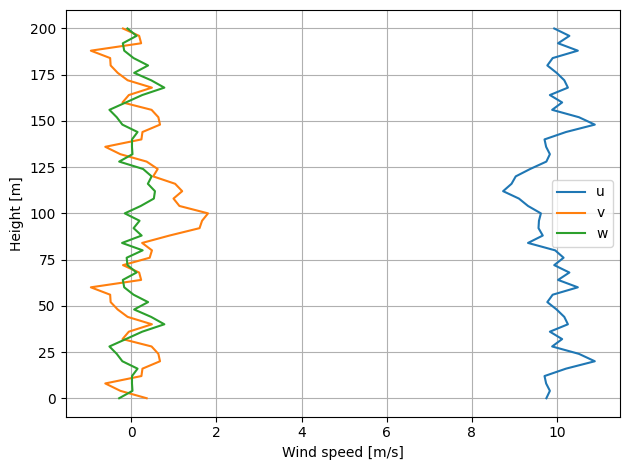

In [15]:
view = ZView(x=0,y=0, z=np.linspace(1,200))
uvw = site.get_windspeed(view)
for ws, n in zip(uvw, 'uvw'):
    plt.plot(ws, view.z, label=n)
setup_plot(xlabel='Wind speed [m/s]', ylabel='Height [m]')

#### Turbulence offset

The `turbulence_offset` argument of `TurbulenceFieldSite` specifies the turbulence field origo at time=0

In [16]:
view = XYView(z=100)
axes = plt.subplots(2,1, figsize=(8,5))[1]
for offset, ax in zip([(0,0,0), (200,100,0)], axes):
        site = TurbulenceFieldSite(ws=10, turbulenceField=mtf, turbulence_offset = offset)
        fs = DefaultDWMFlowSimulation(site=site)
        uvw = fs.get_windspeed(view, include_wakes=False, xarray=True)
        uvw.sel(uvw='u').plot(ax=ax)
        ax.axis('scaled')
        ax.set_xlim([-50,1000])
        ax.set_ylim([0,250])
        ax.set_title(f'Offset: {offset}, time: 0')

#### Turbulence transport speed
The `turbulence_transport_speed` argument of TurbulenceFieldSite specifies the advection speed of the turbulence field

In [17]:
view = XYView(z=100)
axes = plt.subplots(2,1, figsize=(8,5))[1]
for transport_speed, ax in zip([10,20], axes):
        site = TurbulenceFieldSite(ws=10, turbulenceField=mtf, turbulence_transport_speed=transport_speed)
        fs = DefaultDWMFlowSimulation(site=site)
        fs.run(10) # run 10s
        uvw = fs.get_windspeed(view, include_wakes=False, xarray=True)
        uvw.sel(uvw='u').plot(ax=ax) # plot u component
        ax.axis('scaled')
        ax.set_xlim([-50,1000])
        ax.set_ylim([0,250])
        ax.set_title(f'Transport speed: {transport_speed}m/s, time: {fs.time}s')